In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import defaultdict

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [2]:
file_path = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/plot_imem_data_ideal.npy' 
imem_data = np.load(file_path, allow_pickle=True).item()

# Make subset data dictionary for Im plots
target_freqs = [10, 100, 1000]

subset_imem_data = {}

for cell_name, cell_data in imem_data.items():
    freqs = np.array(cell_data['freqs'])
    
    # Find indices corresponding to 10, 100, and 1000 Hz
    freq_indices = [np.argmin(np.abs(freqs - f)) for f in target_freqs]
    
    # Extract subsets
    imem_amps_subset = np.array(cell_data['imem_amps'])[:, freq_indices].tolist()
    pos_avg_subset = [cell_data['positive_avg_imem_pos'][i] for i in freq_indices]
    neg_avg_subset = [cell_data['negative_avg_imem_pos'][i] for i in freq_indices]
    
    # Build new dictionary for this cell
    subset_imem_data[cell_name] = {
        'freqs': [freqs[i] for i in freq_indices],
        'x': cell_data['x'],
        'z': cell_data['z'],
        'totnsegs': cell_data['totnsegs'],
        'tvec': cell_data['tvec'],
        'imem_amps': imem_amps_subset,
        'closest_z_endpoint': cell_data['closest_z_endpoint'],
        'distant_z_endpoint': cell_data['distant_z_endpoint'],
        'total_len': cell_data['total_len'],
        'symmetry_factor': cell_data['symmetry_factor'],
        'soma_diam': cell_data['soma_diam'],
        'tot_dend_diam': cell_data['tot_dend_diam'],
        'positive_avg_imem_pos': pos_avg_subset,
        'negative_avg_imem_pos': neg_avg_subset
    }

In [3]:
def plot_imem_ideal(subset_imem_data, full_imem_data):
    left_cells = subset_imem_data
    right_cells = full_imem_data

    unique_cells = list(left_cells.keys())
    num_cells = len(unique_cells)
    if num_cells == 0:
        print("No cells to plot.")
        return

    # --- Figure setup ---
    fig = plt.figure(figsize=(10, 3 * num_cells))
    main_gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.8, 1], wspace=0.4)

    # --- LEFT PANEL (subset_imem_data with broken axis) ---
    gs_left = gridspec.GridSpecFromSubplotSpec(
        num_cells, 3, subplot_spec=main_gs[0, 0], width_ratios=[1, 1.2, 1.2], wspace=0.2, hspace=0.5
    )

    axs_left_panel = {}
    for i, label in enumerate(unique_cells):
        axs_left_panel[label] = {
            'morph': fig.add_subplot(gs_left[i, 0]),
            'imem_left': fig.add_subplot(gs_left[i, 1]),
            'imem_right': fig.add_subplot(gs_left[i, 2], sharey=fig.axes[-1] if i > 0 else None),
        }

    colors_neurons = ['tab:red', 'tab:blue']

    for i, (label, ax_dict) in enumerate(axs_left_panel.items()):
        cell_data = left_cells[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        freqs = np.array(cell_data['freqs'])
        imem_amps = np.array(cell_data['imem_amps'])
        z_coords = z.mean(axis=-1)

        # --- Morphology plot
        ax_morph = ax_dict['morph']
        color = colors_neurons[i % len(colors_neurons)]
        for idx in range(totnsegs):
            ax_morph.plot(x[idx], z[idx], c=color, lw=2)
        ax_morph.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='black', markersize=4)
        ax_morph.set_xlim(-np.max(z) * 0.3, np.max(z) * 0.3)
        name = 'Long neuron' if 'BL_-500_UL_1000' in label else 'Short neuron'
        ax_morph.set_title(name, fontsize=10, x=0.5, y=1.06)
        ax_morph.set_aspect('equal')
        ax_morph.set_xticks([])
        ax_morph.set_frame_on(False)

        # --- Imem scatter plots with broken axis
        ax_imem_left = ax_dict['imem_left']
        ax_imem_right = ax_dict['imem_right']
        colors_imem = ['tab:purple', 'tab:orange', 'tab:green']

        for f_idx, f in enumerate(freqs):
            z_imem_map = defaultdict(float)
            for seg_idx in range(totnsegs):
                z_imem_map[z_coords[seg_idx]] += imem_amps[seg_idx][f_idx]
            z_vals, imem_vals = list(z_imem_map.keys()), list(z_imem_map.values())

            marker, markersize, alpha = ('o', 25, 1) if f == 10 else (('x', 10, 1) if f == 100 else ('^', 10, 1))
            ax_imem_left.scatter(imem_vals, z_vals, color=colors_imem[f_idx], alpha=alpha, marker=marker, s=markersize)
            ax_imem_right.scatter(imem_vals, z_vals, color=colors_imem[f_idx], alpha=alpha, marker=marker, s=markersize, label=f'{int(f)} Hz')

        # --- Formatting for the broken axis
        xlim1 = (0, 4e-5)
        xlim2 = (0.002, None)
        ax_imem_left.set_xlim(xlim1)
        if xlim2[1] is None:
            xmax = max([max(v) for v in imem_amps.T])
            ax_imem_right.set_xlim((xlim2[0], xmax + 0.0001))
        else:
            ax_imem_right.set_xlim(xlim2)

        ax_imem_left.spines['right'].set_visible(False)
        ax_imem_right.spines['left'].set_visible(False)
        ax_imem_left.yaxis.tick_left()
        ax_imem_left.set_ylabel('z [µm]')
        ax_imem_right.yaxis.set_visible(False)
        ax_imem_right.yaxis.set_label_position('right')
        ax_imem_left.tick_params(labelleft=True)

        # Add diagonal break marks
        d = .015
        kwargs = dict(transform=ax_imem_left.transAxes, color='k', clip_on=False)
        ax_imem_left.plot((1 - d, 1 + d), (-d, +d), **kwargs)
        ax_imem_left.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
        kwargs.update(transform=ax_imem_right.transAxes)
        ax_imem_right.plot((-d, +d), (-d, +d), **kwargs)
        ax_imem_right.plot((-d, +d), (1 - d, 1 + d), **kwargs)

        if i == 0:
            ax_imem_right.legend(loc='best', fontsize='small')

    # Single x-label 
    fig.text(0.37, -0.0, '$I_\\mathrm{m}$ amplitudes [nA]', ha='center', fontsize=10)

    # --- RIGHT PANEL (full_imem_data) ---
    gs_right = gridspec.GridSpecFromSubplotSpec(
        num_cells, 1, subplot_spec=main_gs[0, 1], hspace=0.5
    )

    for i, label in enumerate(unique_cells):
        ax = fig.add_subplot(gs_right[i, 0])
        cell_data = right_cells[label]

        freqs = np.array(cell_data['freqs'])
        pos_avg = np.array(cell_data['positive_avg_imem_pos'])
        neg_avg = np.array(cell_data['negative_avg_imem_pos'])

        name = 'Long neuron' if 'BL_-500_UL_1000' in label else 'Short neuron'
        color = 'tab:red' if 'Long' in name else 'tab:blue'

        ax.plot(freqs, pos_avg, 'o-', color=color, label='Above Soma', markersize=4)
        ax.plot(freqs, neg_avg, 'x--', color=color, label='Below Soma', markersize=4)

        ax.set_xscale('log')
        ax.grid(True, ls='--', alpha=0.6)
        ax.set_ylim(-300, 550)
        ax.set_title(name, fontsize=10)
        ax.set_ylabel('$\\lambda_\\mathrm{AC}$ (µm)', fontsize=11)
        ax.legend(fontsize='x-small', loc='best')
    # Single x-label 
    fig.text(0.77, -0.0, 'Frequency (Hz)', ha='center', fontsize=10)
    
    # ===== Panel labels =====
    fig.text(0.1, 0.96, 'A', fontsize=12, fontweight='bold')
    fig.text(0.21, 0.96, 'B', fontsize=12, fontweight='bold')
    fig.text(0.62, 0.96, 'C', fontsize=12, fontweight='bold')

    plt.show()

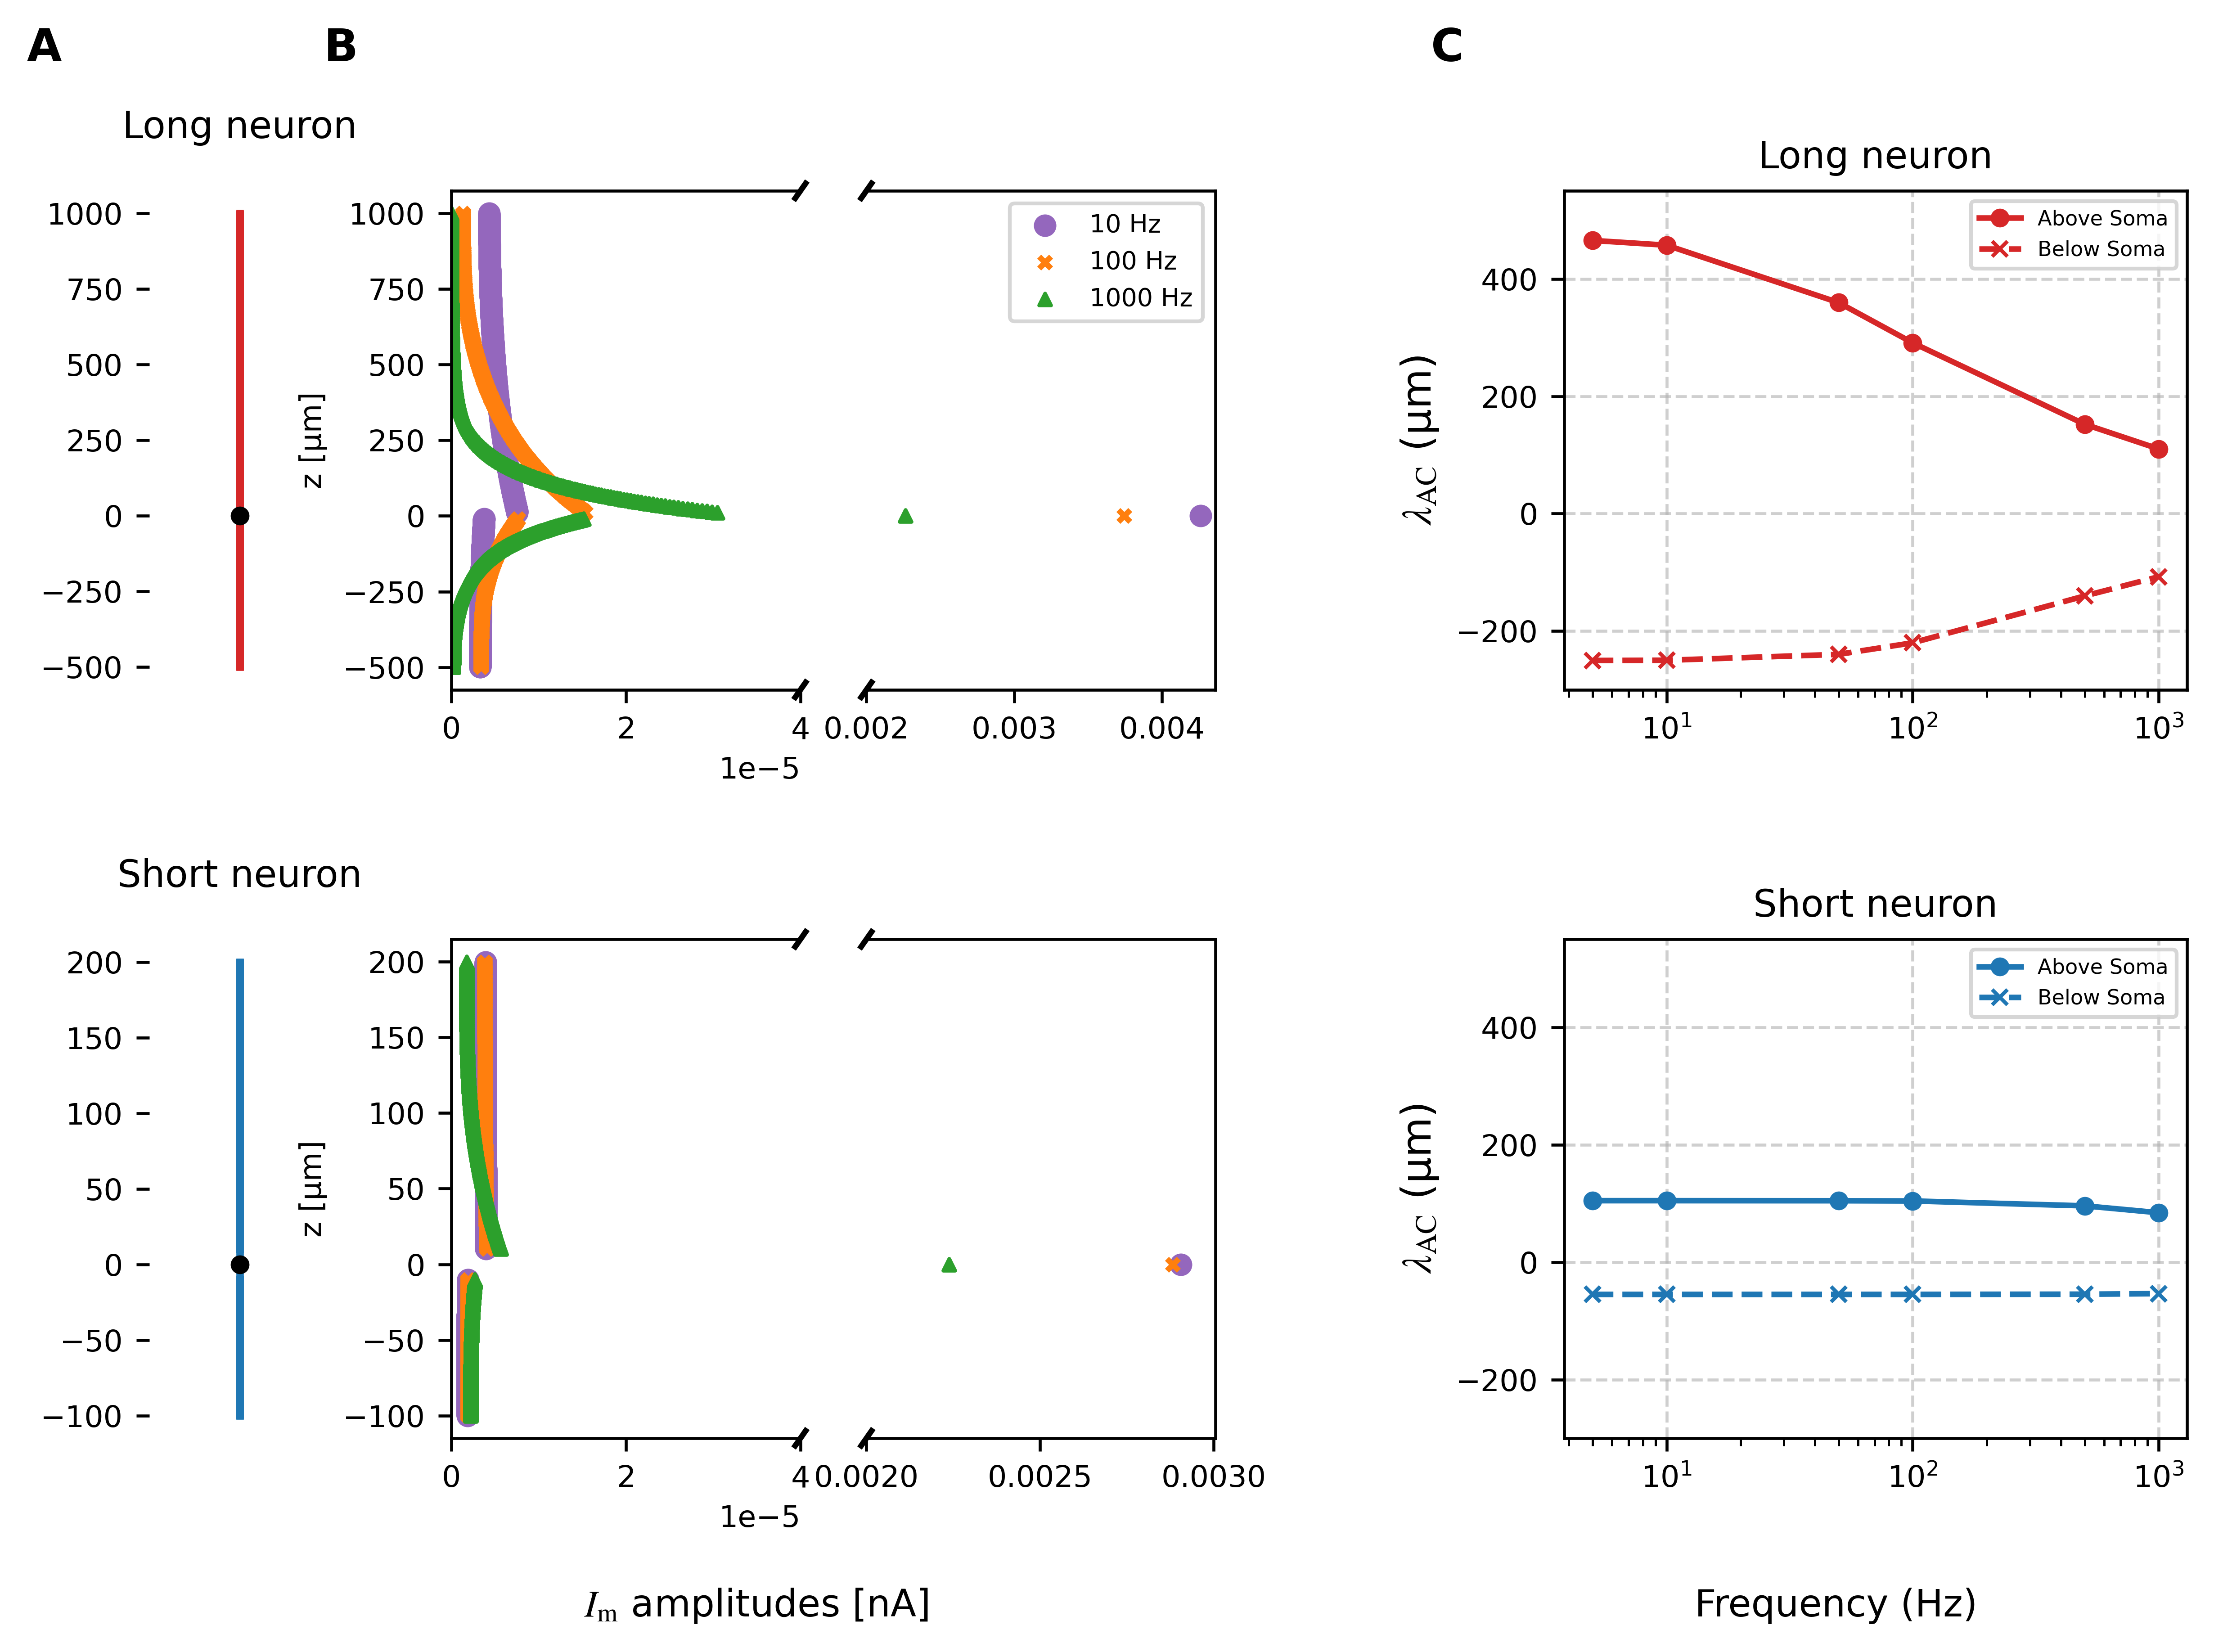

In [4]:
plot_imem_ideal(subset_imem_data, imem_data)